In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.metrics import smape
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df_ = pd.read_csv('/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_data/submkt_train_data/pho_submkt_train_test_data.csv',index_col=0)
df = df_[['date','research_submkt_id','real_hedonic_rent_submarket']]

In [3]:
df_[(df_['research_submkt_id']=='PHO037')&(df_['date']>='2000-01-01')][['date','real_hedonic_rent_submarket']].head(20)

,date,real_hedonic_rent_submarket
933,2000-01-01,8.372650
973,2000-02-01,8.490358
1013,2000-03-01,8.510449
1053,2000-04-01,8.533470
1093,2000-05-01,8.491754
1133,2000-06-01,8.480505
1173,2000-07-01,8.516866
1213,2000-08-01,8.490632
1253,2000-09-01,8.460014
1293,2000-10-01,8.440398


In [4]:
df['date'] = pd.to_datetime(df['date'])
df_['date'] = pd.to_datetime(df_['date'])
num_lags = 36  
for lag in range(1, num_lags+1):
    df['rent_{}months_ago'.format(lag)] = df.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
df = df.dropna()
df = df.sort_values(['date', 'research_submkt_id']).reset_index(drop=True)
df.head()

/tmp/ipykernel_93592/2963728722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/tmp/ipykernel_93592/2963728722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rent_{}months_ago'.format(lag)] = df.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_93592/2963728722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,date,research_submkt_id,real_hedonic_rent_submarket,rent_1months_ago,rent_2months_ago,rent_3months_ago,rent_4months_ago,rent_5months_ago,rent_6months_ago,rent_7months_ago,...,rent_27months_ago,rent_28months_ago,rent_29months_ago,rent_30months_ago,rent_31months_ago,rent_32months_ago,rent_33months_ago,rent_34months_ago,rent_35months_ago,rent_36months_ago
0,2001-02-01,PHO037,9.242010,8.429784,8.472680,8.476210,8.440398,8.460014,8.490632,8.516866,...,9.610935,9.634394,9.570888,9.563742,9.554956,9.482935,9.518826,9.448461,9.464508,9.484685
1,2001-02-01,PHO038,6.896505,6.868247,6.875076,6.895329,6.898706,6.878764,6.887355,6.904910,...,7.462034,7.444337,7.453295,7.453660,7.437837,7.420603,7.417174,7.406815,7.399666,7.399728
2,2001-02-01,PHO039,7.501193,7.772118,7.772109,7.775501,7.769183,7.745279,7.759696,7.748712,...,7.267412,7.226943,7.235870,7.229108,7.194493,7.178172,7.169188,7.149265,7.152005,7.152797
3,2001-02-01,PHO040,8.479733,8.370461,8.273728,8.232606,8.243495,8.240890,8.118420,8.133908,...,6.491422,6.446314,6.402784,6.359236,6.345820,6.364228,6.340928,6.337453,6.349049,6.404895
4,2001-02-01,PHO041,8.154634,8.233423,8.248912,8.219992,8.181149,8.176995,8.201208,8.180075,...,7.481804,7.437793,7.445833,7.444910,7.405700,7.386858,7.375575,7.375186,7.389464,7.409317


In [5]:
df_sel = df_[["date", 
            "research_submkt_id",
            "gdp_histfc",
            "nominal_retail_sales_histfc",
            "employment_histfc",
            "real_ecommerce",
            "spread_3m10y",
            "real_retail_sales_ex_gas",
            "imports_us",
            "ecomm^2_pop",
            "weighted_pop_estimate_cryr",
            "weighted_hh_estimate_cryr"]]

In [6]:
df_new = df.merge(df_sel,on=['date','research_submkt_id'],how='left')

In [7]:
df_new = df_new.sort_values(['date', 'research_submkt_id']).reset_index(drop=True)
df_new.head()

,date,research_submkt_id,real_hedonic_rent_submarket,rent_1months_ago,rent_2months_ago,rent_3months_ago,rent_4months_ago,rent_5months_ago,rent_6months_ago,rent_7months_ago,...,gdp_histfc,nominal_retail_sales_histfc,employment_histfc,real_ecommerce,spread_3m10y,real_retail_sales_ex_gas,imports_us,ecomm^2_pop,weighted_pop_estimate_cryr,weighted_hh_estimate_cryr
0,2001-02-01,PHO037,9.242010,8.429784,8.472680,8.476210,8.440398,8.460014,8.490632,8.516866,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.31117,185.707296,0.814154,57298.031721,16953.789162
1,2001-02-01,PHO038,6.896505,6.868247,6.875076,6.895329,6.898706,6.878764,6.887355,6.904910,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.31117,185.707296,0.814154,423462.954153,176776.235264
2,2001-02-01,PHO039,7.501193,7.772118,7.772109,7.775501,7.769183,7.745279,7.759696,7.748712,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.31117,185.707296,0.814154,206665.753345,84755.250151
3,2001-02-01,PHO040,8.479733,8.370461,8.273728,8.232606,8.243495,8.240890,8.118420,8.133908,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.31117,185.707296,0.814154,75439.315463,26879.287920
4,2001-02-01,PHO041,8.154634,8.233423,8.248912,8.219992,8.181149,8.176995,8.201208,8.180075,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.31117,185.707296,0.814154,114035.858867,46457.095067


In [ ]:
X = df_new.iloc[:, [0, 1] + list(range(3, len(df_new.columns)))]
Y = df_new.iloc[:,:3]

def split_data_by_submarket(data, train_ratio):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    submarkets = data['research_submkt_id'].unique()

    for submarket in submarkets:
        submarket_data = data[data['research_submkt_id'] == submarket]
        train_size = int(len(submarket_data) * train_ratio)
        train_submarket = submarket_data.iloc[:train_size]
        test_submarket = submarket_data.iloc[train_size:]
        train_data = pd.concat([train_data, train_submarket])
        test_data = pd.concat([test_data, test_submarket])

    return train_data, test_data


In [8]:
X = df_new.iloc[:, [0, 1] + list(range(3, len(df_new.columns)))]
Y = df_new.iloc[:,:3]
def ntest_split_data_by_submarket(data, ntest):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    submarkets = data['research_submkt_id'].unique()

    for submarket in submarkets:
        submarket_data = data[data['research_submkt_id'] == submarket]
        train_submarket = submarket_data.iloc[:-ntest]
        test_submarket = submarket_data.iloc[-ntest:]
        train_data = pd.concat([train_data, train_submarket])
        test_data = pd.concat([test_data, test_submarket])

    return train_data, test_data

In [11]:
Y_train, Y_test = ntest_split_data_by_submarket(Y, 24)
y_train = Y_train.iloc[:,-1]
y_test = Y_test.iloc[:,-1]
X_train, X_test = ntest_split_data_by_submarket(X, 24)
x_train = X_train.iloc[:,2:]
x_test = X_test.iloc[:,2:]

In [22]:
y_train

0       9.242010
27      9.250835
54      9.224063
81      9.111098
108     8.983725
          ...   
6729    7.223044
6757    7.236465
6785    7.289558
6813    7.314317
6841    7.388067
Name: real_hedonic_rent_submarket, Length: 6852, dtype: float64

In [ ]:
X_train[X_train['research_submkt_id']=='PHO037']

In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

model = XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score (RMSE):", best_score)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score (RMSE): 0.023489323968802867


In [16]:
best_model = XGBRegressor(**best_params)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

In [18]:
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: SMAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape_value = smape(y_test, y_pred)
print(f"SMAPE: {smape_value:.2f}%")

SMAPE: 1.09%


In [19]:
Y_test_pred = Y_test.copy()
Y_test_pred['y_pred'] = y_pred
Y_test_pred.head()

,date,research_submkt_id,real_hedonic_rent_submarket,y_pred
6852,2021-08-01,PHO037,6.865879,6.860144
6880,2021-09-01,PHO037,6.895755,6.872582
6908,2021-10-01,PHO037,6.935858,6.898119
6936,2021-11-01,PHO037,6.996811,6.897058
6964,2021-12-01,PHO037,7.021086,6.957999


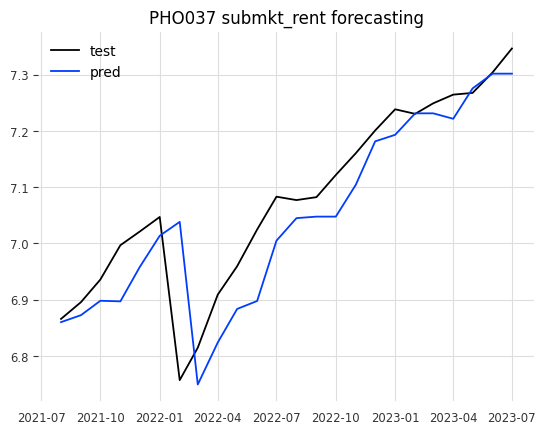

In [20]:
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO037']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO037']['real_hedonic_rent_submarket'],label='test')
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO037']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO037']['y_pred'],label='pred')
plt.title('PHO037 submkt_rent forecasting')
plt.legend()
plt.show;

In [ ]:
smape(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO037']['real_hedonic_rent_submarket'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO037']['y_pred'])

In [ ]:
#plt.plot(Y_train[Y_train['research_submkt_id']=='PHO038']['date'],Y_train[Y_train['research_submkt_id']=='PHO038']['real_hedonic_rent_submarket'])

plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO038']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO038']['real_hedonic_rent_submarket'])
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO038']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO038']['y_pred'])

In [ ]:
smape(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO038']['real_hedonic_rent_submarket'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO038']['y_pred'])

In [ ]:
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO039']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO039']['real_hedonic_rent_submarket'])
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO039']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO039']['y_pred'])

In [ ]:
smape(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO039']['real_hedonic_rent_submarket'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO039']['y_pred'])

In [ ]:
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO040']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO040']['real_hedonic_rent_submarket'])
plt.plot(Y_test_pred[Y_test_pred['research_submkt_id']=='PHO040']['date'],Y_test_pred[Y_test_pred['research_submkt_id']=='PHO040']['y_pred'])